In [1]:
import awkward as awk
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from matplotlib.colors import LogNorm
plt.style.use("../figures.mplstyle")
import numpy as np
import os
try: os.mkdir("figures")
except FileExistsError: pass

import nuflux

import siren
from siren.SIREN_Controller import SIREN_Controller

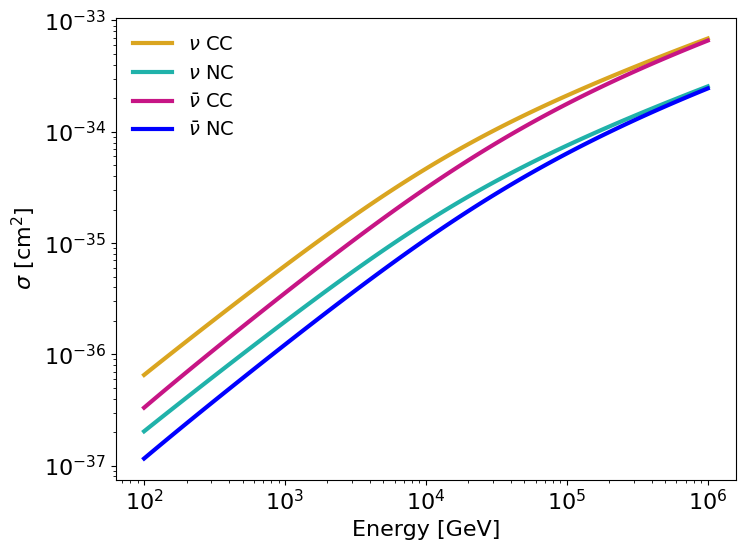

In [2]:
# Particle to inject
nue = siren.dataclasses.Particle.ParticleType.NuE
nuebar = siren.dataclasses.Particle.ParticleType.NuEBar
numu = siren.dataclasses.Particle.ParticleType.NuMu
numubar = siren.dataclasses.Particle.ParticleType.NuMuBar
nutau = siren.dataclasses.Particle.ParticleType.NuTau
nutaubar = siren.dataclasses.Particle.ParticleType.NuTauBar

particles = [nue,nuebar,numu,numubar,nutau,nutaubar]

# target mass
target_mass = 0.5 * (0.938272 + 0.939565)

cross_section_model = "CSMSDISSplines"

xsfiledir = siren.utilities.get_cross_section_model_path(cross_section_model)

# Cross Section Model
target_type = siren.dataclasses.Particle.ParticleType.Nucleon

DIS_xs_CC = siren.interactions.DISFromSpline(
    os.path.join(xsfiledir, "dsdxdy_nu_CC_iso.fits"),
    os.path.join(xsfiledir, "sigma_nu_CC_iso.fits"),
    1, # interaction type
    target_mass, # taget mass [GeV]
    1., # min Q^2 [GeV^2]
    [nue,numu,nutau], # primary types
    [target_type], "m"
)

DIS_xs_NC = siren.interactions.DISFromSpline(
    os.path.join(xsfiledir, "dsdxdy_nu_NC_iso.fits"),
    os.path.join(xsfiledir, "sigma_nu_NC_iso.fits"),
    2, # interaction type
    target_mass, # taget mass [GeV]
    1., # min Q^2 [GeV^2]
    [nue,numu,nutau], # primary types
    [target_type], "m"
)

DIS_xs_CCbar = siren.interactions.DISFromSpline(
    os.path.join(xsfiledir, "dsdxdy_nubar_CC_iso.fits"),
    os.path.join(xsfiledir, "sigma_nubar_CC_iso.fits"),
    1, # interaction type
    target_mass, # taget mass [GeV]
    1., # min Q^2 [GeV^2]
    [nuebar,numubar,nutaubar], # primary types
    [target_type], "m"
)

DIS_xs_NCbar = siren.interactions.DISFromSpline(
    os.path.join(xsfiledir, "dsdxdy_nubar_NC_iso.fits"),
    os.path.join(xsfiledir, "sigma_nubar_NC_iso.fits"),
    2, # interaction type
    target_mass, # taget mass [GeV]
    1., # min Q^2 [GeV^2]
    [nuebar,numubar,nutaubar], # primary types
    [target_type], "m"
)

labels = {"CC_nu":r"$\nu$ CC",
          "NC_nu":r"$\nu$ NC",
          "CC_nubar":r"$\bar{\nu}$ CC",
          "NC_nubar":r"$\bar{\nu}$ NC"}

primary_xs = {"CC_nu":siren.interactions.InteractionCollection(numu, [DIS_xs_CC]),
              "NC_nu":siren.interactions.InteractionCollection(numu, [DIS_xs_NC]),
              "CC_nubar":siren.interactions.InteractionCollection(numubar, [DIS_xs_CCbar]),
              "NC_nubar":siren.interactions.InteractionCollection(numubar, [DIS_xs_NCbar])}


erange = np.logspace(2,6,100)

for k,xs in primary_xs.items():
    primary_type = numubar if "bar" in k else numu
    plt.plot(erange,[primary_xs[k].GetCrossSectionsForTarget(target_type)[0].TotalCrossSection(primary_type,e) for e in erange],label=labels[k])
plt.loglog()
plt.legend()
plt.xlabel("Energy [GeV]")
plt.ylabel(r"$\sigma~[{\rm cm}^2]$")
plt.show()






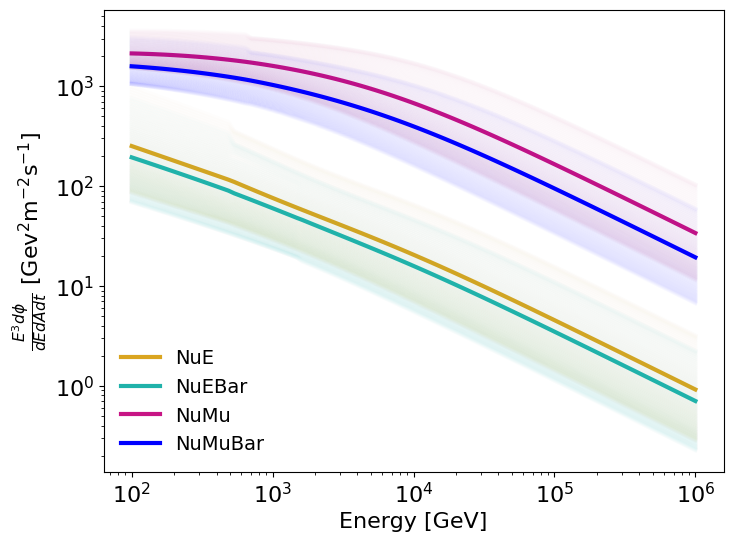

In [3]:
flux = nuflux.makeFlux('honda2006')
nu_type=nuflux.NuMu
erange_atmo = np.logspace(2,6,100)
cosrange = np.linspace(0,1,100)
atmo_flux_tables = {}
cycler = plt.rcParams['axes.prop_cycle']()
for particle,c in zip([nuflux.NuE,
                 nuflux.NuEBar,
                 nuflux.NuMu,
                 nuflux.NuMuBar],cycler):
    color = c["color"]
    siren_key = siren.dataclasses.Particle.ParticleType(int(particle))
    atmo_flux_tables[siren_key] = np.zeros(len(erange))
    for cost in cosrange:
        plt.plot(erange,erange**3*flux.getFlux(particle,erange,cost) * 1e4 * 2 * np.pi,color=color,alpha=0.01)
    for i,e in enumerate(erange):
        f = flux.getFlux(particle,e,cosrange)
        atmo_flux_tables[siren_key][i] += 0.01*np.sum(f) * 1e4 * 2 * np.pi
    plt.plot(erange,erange**3*atmo_flux_tables[siren_key],color=color,label=particle)

plt.xlabel("Energy [GeV]")
plt.ylabel(r"$\frac{E^3 d\phi}{dE dA dt}$ $[ {\rm Gev}^2 {\rm m}^{-2} {\rm s}^{-1} ]$")
plt.legend()
plt.loglog()
plt.show()

In [4]:
# Number of events to inject
events_to_inject = int(1e5)
# Expeirment to run
experiment = "IceCube"
os.makedirs("output", exist_ok=True)

for primary_type in particles:
    
    if os.path.isfile("output/IceCube_DIS_%d.siren_events"%(primary_type)): continue
    
    
    controller = SIREN_Controller(events_to_inject, experiment)
    
    # DIS cross section
    if int(primary_type)>0:
        xs = siren.interactions.InteractionCollection(primary_type, [DIS_xs_CC,DIS_xs_NC])
    else:
        xs = siren.interactions.InteractionCollection(primary_type, [DIS_xs_CCbar,DIS_xs_NCbar])
    controller.SetInteractions(xs,physical=False) # only set injection cross sections

    # Primary distributions
    primary_injection_distributions = {}
    
    # mass
    primary_injection_distributions["mass"] = siren.distributions.PrimaryMass(0)
    
    # energy
    primary_injection_distributions["energy"] = siren.distributions.PowerLaw(1, 1e2, 1e6)

    # direction
    primary_injection_distributions["direction"] = siren.distributions.IsotropicDirection()

    # position
    muon_range_func = siren.distributions.LeptonDepthFunction()
    position_distribution = siren.distributions.ColumnDepthPositionDistribution(
        1200, 1200.0, muon_range_func, set(controller.GetDetectorModelTargets()[0])
    )
    primary_injection_distributions["position"] = position_distribution

    # set processes
    controller.SetInjectionProcesses(
        primary_type, primary_injection_distributions
    )

    controller.InitializeInjector()

    events = controller.GenerateEvents()

    controller.SaveEvents("output/IceCube_DIS_%d"%(primary_type),hdf5=False)

In [5]:
def ReweightEvents(primary_type, mode):
    
    controller = SIREN_Controller(0, experiment)
    
    # DIS cross section
    if int(primary_type)>0:
        xs = siren.interactions.InteractionCollection(primary_type, [DIS_xs_CC,DIS_xs_NC])
    else:
        xs = siren.interactions.InteractionCollection(primary_type, [DIS_xs_CCbar,DIS_xs_NCbar])
    
    controller.SetInteractions(xs,injection=False) # only set physical cross sections

    # Primary distributions
    primary_physical_distributions = {}
    
    # mass
    primary_physical_distributions["mass"] = siren.distributions.PrimaryMass(0)
    
    # energy
    if mode=="astro":
        edist_astro = siren.distributions.PowerLaw(2, 1e2, 1e6)
        norm = 1e-18 * 1e4 * 4 * np.pi # GeV^-1 m^-2 s^-1
        edist_astro.SetNormalizationAtEnergy(norm,1e5)
    elif mode=="atmo":
        edist_atmo = siren.distributions.TabulatedFluxDistribution(erange_atmo,atmo_flux_tables[primary_type],True)
    primary_physical_distributions["energy"] = edist_atmo if mode=="atmo" else edist_astro

    # direction
    primary_physical_distributions["direction"] = siren.distributions.IsotropicDirection()

    # set processes
    controller.SetPhysicalProcesses(
        primary_type, primary_physical_distributions
    )

    controller.Initialize(injection_filenames=["output/IceCube_DIS_%d"%(primary_type)])
    
    controller.LoadEvents("output/IceCube_DIS_%d"%(primary_type))

    controller.SaveEvents("output/IceCube_DIS_%d_%s"%(primary_type,mode),hdf5=False,parquet=True)

In [6]:
data = {}
for mode in ["atmo","astro"]:
    data[mode] = {}
    for primary_type in particles:
        if mode=="atmo" and abs(int(primary_type))==16: continue
        if not os.path.isfile("output/IceCube_DIS_%d_%s.parquet"%(primary_type,mode)):
            ReweightEvents(primary_type, mode)
        data[mode][primary_type] = awk.from_parquet("output/IceCube_DIS_%d_%s.parquet"%(primary_type,mode))

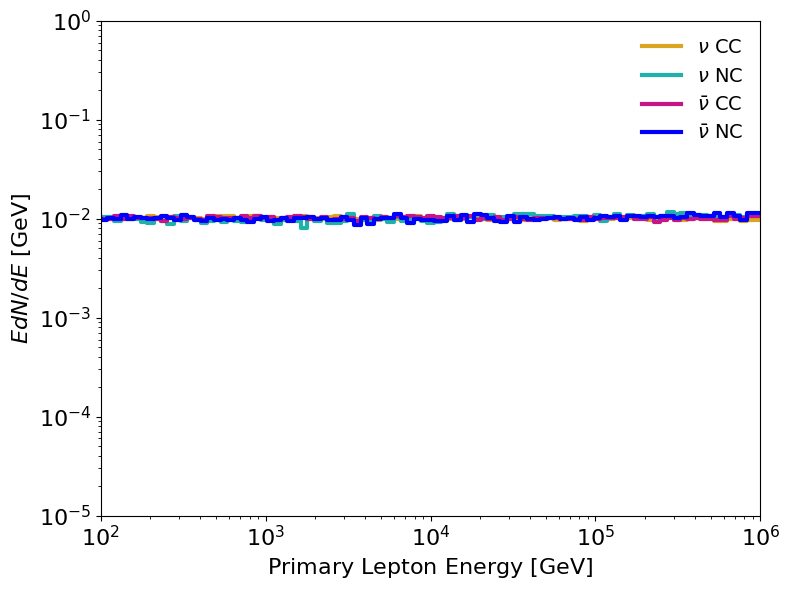

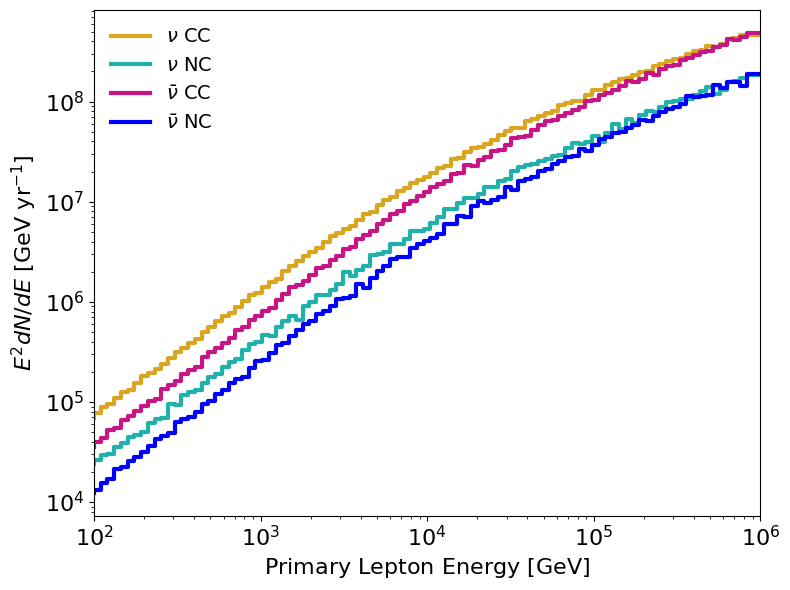

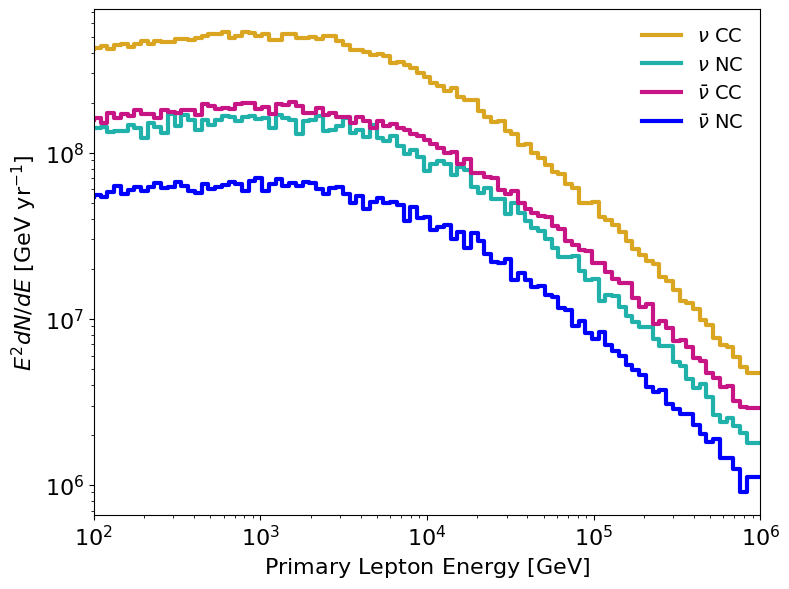

In [7]:

bins = np.logspace(2,6,100)
bw = bins[1:] - bins[:-1]
livetime = 60*60*24*365 # s yr^-1

# unweighted astro
rates = {k:np.zeros(len(bins)-1) for k in labels.keys()}
for primary_type,dataset in data["astro"].items():
    NC_flag = np.squeeze(np.any(dataset.secondary_types==int(primary_type),axis=-1))
    nu_energy = np.squeeze(dataset.primary_momentum)[:,0]
    lepton_energy = np.squeeze(dataset.secondary_momenta)[:,0,0]
    nNC,_ = np.histogram(nu_energy[NC_flag],weights=nu_energy[NC_flag],bins=bins)
    yNC = np.array(nNC/bw)
    nCC,_ = np.histogram(nu_energy[~NC_flag],weights=nu_energy[~NC_flag],bins=bins)
    yCC = np.array(nCC/bw)
    if int(primary_type)>0:
        rates["CC_nu"] += yCC
        rates["NC_nu"] += yNC
    else:
        rates["CC_nubar"] += yCC
        rates["NC_nubar"] += yNC
for k,rate in rates.items():
    rate /= np.sum(rate)
    plt.step(bins,np.append(rate,rate[-1]),label=labels[k])
plt.xlim(1e2,1e6)
plt.ylim(1e-5,1e0)
plt.loglog()
plt.legend()
plt.ylabel(r"$E dN/dE~{\rm [GeV]}$")
plt.xlabel(r"Primary Lepton Energy$~[{\rm GeV}]$")
plt.tight_layout()
plt.savefig("figures/rates_gen.pdf",dpi=100)
plt.show()

# astrophysical
rates = {k:np.zeros(len(bins)-1) for k in labels.keys()}
for primary_type,dataset in data["astro"].items():
    NC_flag = np.squeeze(np.any(dataset.secondary_types==int(primary_type),axis=-1))
    nu_energy = np.squeeze(dataset.primary_momentum)[:,0]
    lepton_energy = np.squeeze(dataset.secondary_momenta)[:,0,0]
    nNC,_ = np.histogram(nu_energy[NC_flag],weights=livetime*dataset.event_weight[NC_flag]*nu_energy[NC_flag]**2,bins=bins)
    yNC = np.array(nNC/bw)
    nCC,_ = np.histogram(nu_energy[~NC_flag],weights=livetime*dataset.event_weight[~NC_flag]*nu_energy[~NC_flag]**2,bins=bins)
    yCC = np.array(nCC/bw)
    if int(primary_type)>0:
        rates["CC_nu"] += yCC
        rates["NC_nu"] += yNC
    else:
        rates["CC_nubar"] += yCC
        rates["NC_nubar"] += yNC
for k,rate in rates.items():
    plt.step(bins,np.append(rate,rate[-1]),label=labels[k])
plt.xlim(1e2,1e6)
plt.loglog()
plt.legend()
plt.ylabel(r"$E^2 dN/dE~[{\rm GeV~yr}^{-1}]$")
plt.xlabel(r"Primary Lepton Energy$~[{\rm GeV}]$")
plt.tight_layout()
plt.savefig("figures/rates_astro.pdf",dpi=100)
plt.show()

# atmospheric
rates = {k:np.zeros(len(bins)-1) for k in labels.keys()}
for primary_type,dataset in data["atmo"].items():
    NC_flag = np.squeeze(np.any(dataset.secondary_types==int(primary_type),axis=-1))
    nu_energy = np.squeeze(dataset.primary_momentum)[:,0]
    lepton_energy = np.squeeze(dataset.secondary_momenta)[:,0,0]
    nNC,_ = np.histogram(nu_energy[NC_flag],weights=livetime*dataset.event_weight[NC_flag]*nu_energy[NC_flag]**2,bins=bins)
    yNC = np.array(nNC/bw)
    nCC,_ = np.histogram(nu_energy[~NC_flag],weights=livetime*dataset.event_weight[~NC_flag]*nu_energy[~NC_flag]**2,bins=bins)
    yCC = np.array(nCC/bw)
    if int(primary_type)>0:
        rates["CC_nu"] += yCC
        rates["NC_nu"] += yNC
    else:
        rates["CC_nubar"] += yCC
        rates["NC_nubar"] += yNC
for k,rate in rates.items():
    plt.step(bins,np.append(rate,rate[-1]),label=labels[k])
plt.xlim(1e2,1e6)
plt.loglog()
plt.legend()
plt.ylabel(r"$E^2 dN/dE~[{\rm GeV~yr}^{-1}]$")
plt.xlabel(r"Primary Lepton Energy$~[{\rm GeV}]$")
plt.tight_layout()
plt.savefig("figures/rates_atmo.pdf",dpi=100)
plt.show()